In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [17]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [14]:
# Save references to each table
measurements = Base.classes.measurement
stations = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [18]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [19]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [33]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [74]:
# Find the most recent date in the data set.
most_recent = session.query(measurements.date).order_by(measurements.date.desc()).first()
most_recent

('2017-08-23',)

In [136]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

#most_recent_string just equals the string '2017-08-23'
most_recent_string = most_recent[0]
#convert to datetime
most_recent_dt = pd.to_datetime(most_recent_string)

# Calculate the date one year from the last date in data set.
one_year_before = most_recent_dt - pd.DateOffset(years=1)

start_date = str(one_year_before)[0:10]
start_date

'2016-08-23'

In [78]:
# Perform a query to retrieve the data and precipitation scores
data = session.query(measurements.date,measurements.prcp).\
    filter(measurements.date >= str(one_year_before)[0:10])
data_rows = [{"Date": row[0],"Precipitation":row[1]} for row in data]
data_rows[0:10]

[{'Date': '2016-08-23', 'Precipitation': 0.0},
 {'Date': '2016-08-24', 'Precipitation': 0.08},
 {'Date': '2016-08-25', 'Precipitation': 0.08},
 {'Date': '2016-08-26', 'Precipitation': 0.0},
 {'Date': '2016-08-27', 'Precipitation': 0.0},
 {'Date': '2016-08-28', 'Precipitation': 0.01},
 {'Date': '2016-08-29', 'Precipitation': 0.0},
 {'Date': '2016-08-30', 'Precipitation': 0.0},
 {'Date': '2016-08-31', 'Precipitation': 0.13},
 {'Date': '2016-09-01', 'Precipitation': 0.0}]

In [79]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(data_rows)
precip_df = precip_df.sort_values("Date").reset_index(drop=True)
precip_df.head()

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-23,NaN
2,2016-08-23,1.79
3,2016-08-23,0.05
4,2016-08-23,0.15


In [80]:
precip_df.shape

(2230, 2)

In [82]:
all_dates = list(precip_df.Date.unique())
len(all_dates)

366

In [93]:
increment = 365 // 5

x_ticks = []
for i in range(0, len(all_dates)-1,increment):
    x_ticks.append(all_dates[i])

x_ticks

['2016-08-23', '2016-11-04', '2017-01-16', '2017-03-30', '2017-06-11']

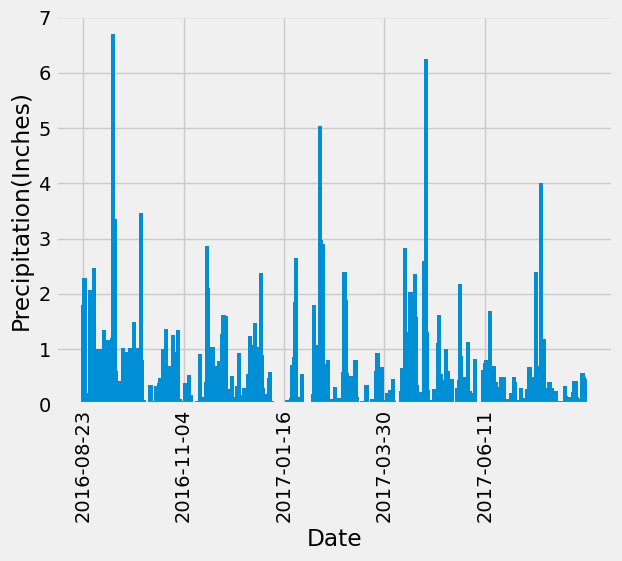

In [98]:
plt.bar(precip_df["Date"],precip_df["Precipitation"],width=3)
plt.xlabel("Date")
plt.ylabel("Precipitation(Inches)")
plt.xticks(ticks=[x for x in range(0,365,increment)],labels = x_ticks,rotation=90)
plt.show()

In [99]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [104]:
# Design a query to calculate the total number of stations in the dataset
num_stations = session.query(stations.id).count()
num_stations

9

In [131]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_query_count = session.query(measurements.station,func.count(measurements.station))\
    .group_by(measurements.station).order_by(func.count(measurements.station).desc()).all()
station_query_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [132]:
Find most active station
most_active = station_query_count[0]
most_active

('USC00519281', 2772)

In [137]:
# Using the most active station id from the previous query
#calculate the lowest, highest, and average temperature.
temperature_query = session.query(func.min(measurements.tobs),\
                                  func.max(measurements.tobs),\
                                  func.avg(measurements.tobs))\
                                .filter(measurements.station == most_active[0]).all()
temperature_query

[(54.0, 85.0, 71.66378066378067)]

In [138]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 
#and plot the results as a histogram
twelve_month_query = session.query(measurements.tobs)\
    .filter(measurements.station == most_active[0]).\
    filter(measurements.date >= start_date).all()
twelve_month_query

[(77.0,),
 (77.0,),
 (80.0,),
 (80.0,),
 (75.0,),
 (73.0,),
 (78.0,),
 (77.0,),
 (78.0,),
 (80.0,),
 (80.0,),
 (78.0,),
 (78.0,),
 (78.0,),
 (73.0,),
 (74.0,),
 (80.0,),
 (79.0,),
 (77.0,),
 (80.0,),
 (76.0,),
 (79.0,),
 (75.0,),
 (79.0,),
 (78.0,),
 (79.0,),
 (78.0,),
 (78.0,),
 (76.0,),
 (74.0,),
 (77.0,),
 (78.0,),
 (79.0,),
 (79.0,),
 (77.0,),
 (80.0,),
 (78.0,),
 (78.0,),
 (78.0,),
 (77.0,),
 (79.0,),
 (79.0,),
 (79.0,),
 (79.0,),
 (75.0,),
 (76.0,),
 (73.0,),
 (72.0,),
 (71.0,),
 (77.0,),
 (79.0,),
 (78.0,),
 (79.0,),
 (77.0,),
 (79.0,),
 (77.0,),
 (78.0,),
 (78.0,),
 (78.0,),
 (78.0,),
 (77.0,),
 (74.0,),
 (75.0,),
 (76.0,),
 (73.0,),
 (76.0,),
 (74.0,),
 (77.0,),
 (76.0,),
 (76.0,),
 (74.0,),
 (75.0,),
 (75.0,),
 (75.0,),
 (75.0,),
 (71.0,),
 (63.0,),
 (70.0,),
 (68.0,),
 (67.0,),
 (77.0,),
 (74.0,),
 (77.0,),
 (76.0,),
 (76.0,),
 (75.0,),
 (76.0,),
 (75.0,),
 (73.0,),
 (75.0,),
 (73.0,),
 (75.0,),
 (74.0,),
 (75.0,),
 (74.0,),
 (75.0,),
 (73.0,),
 (75.0,),
 (73.0,),
 (73.0,),


Text(0.5, 4.183333333333314, 'Temperature')

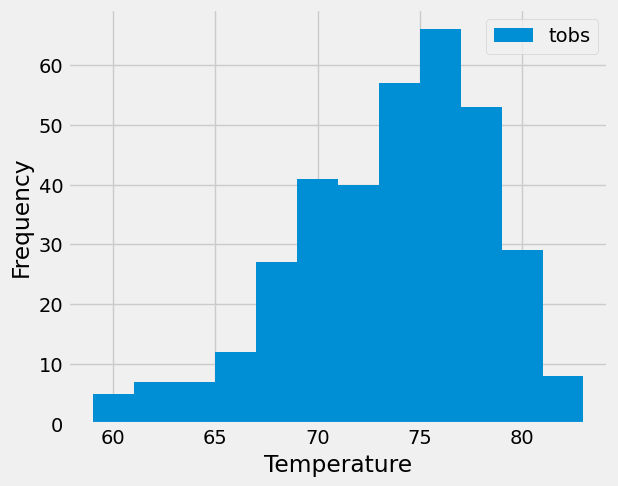

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 
# and plot the results as a histogram


# Close Session

In [139]:
# Close Session
session.close()